# Development of SNAP for Si

## 1. Data loading, Feature analysis and ML model training

### 1.1 Import necessary packages

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from maml.utils import pool_from, convert_docs

# local environment descriptors imports
from maml.describers import BispectrumCoefficients
from sklearn.decomposition import PCA

# machine learning interatomic potentials imports
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# materials properties prediction imports
from pymatgen.core import Structure, Lattice
from maml.apps.pes import LatticeConstant, ElasticConstant, NudgedElasticBand, DefectFormation

# disable logging information
import logging
logging.disable(logging.CRITICAL)

### 1.2 Load DFT data

loadfn - loads json directly from a filename instead of a file-like object

In [2]:
Si_train_data = loadfn('../data/Si/training.json')
Si_test_data = loadfn('../data/Si/test.json')
print(' # of Si training data: {}\n'.format(len(Si_train_data)),
      '# of Si test data: {}\n'.format(len(Si_test_data)))

 # of Si training data: 214
 # of Si test data: 25



### 1.3 Bispectrum coefficients features

Transform each atom in structures to one array of feature, set pot_fit = False

Bispectrum coefficients used to describe the local environment of each atom. Lammps is required to perform this computation.

In [3]:
element_profile = {'Si': {'r': 0.5, 'w': 1.0}}
per_atom_describer = BispectrumCoefficients(rcutfac=4.9, twojmax=8, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=False, 
                                                 include_stress=False)

Si_train_structures = [d['structure'] for d in Si_train_data]
per_atom_features = per_atom_describer.transform(Si_train_structures)

print("Total # of atoms in Si train: {}\n".format(sum([len(struct) for struct in Si_train_structures])), 
      "     # of features generated: {} (one feature per atom)\n".format(per_atom_features.shape[0]),
      "     # of dimensions: {} (for twojmax = 8)".format(per_atom_features.shape[1]))

per_atom_features

Total # of atoms in Si train: 13233
      # of features generated: 13233 (one feature per atom)
      # of dimensions: 55 (for twojmax = 8)


0-0-0     1-0-1     1-1-2     2-0-2     2-1-3     2-2-2  \
input_index                                                                  
0           0   130.0000  1.301410 -0.015867  14.87930 -0.389551 -0.032329   
            1   140.4780  3.122390  0.102866  15.24490 -0.883205 -1.029510   
            2   144.0510  5.227220 -0.547124  11.68850 -1.527110  1.189890   
            3   120.6390  5.330500 -0.676877   7.31921 -0.546470  0.558799   
            4   108.3970  4.871440 -0.553836  15.42270 -0.599690  0.077691   
...                  ...       ...       ...       ...       ...       ...   
213         59   93.4339  0.002279  0.000800  15.36690 -0.035071  3.598060   
            60   93.4339  0.002279  0.000800  15.36690 -0.035071  3.598060   
            61   93.4339  0.002279  0.000800  15.36690 -0.035071  3.598060   
            62   93.4339  0.002279  0.000800  15.36690 -0.035071  3.598060   
            63   93.4339  0.002279  0.000800  15.36690 -0.035071  3.598060   

                   2-2-4    3-0-3     3-1-4    3-2-3  ...    7-3-8    7-4-7  \
input_index                                           ...                     
0           0   2.169110  36.0909  0.200476  1.66009  ...  13.8176  19.5857   
            1   0.651490  41.7741 -1.697880  3.15719  ...  18.5803  13.5183   
            2   0.675705  51.3141  1.324540  3.20623  ...  15.4907  14.0453   
            3   2.181100  29.2113  0.026219  2.81346  ...  12.8554  22.0175   
            4   1.933720  36.5051 -0.494405  3.81368  ...  17.6744  21.4300   
...                  ...      ...       ...      ...  ...      ...      ...   
213         59  8.053990  40.2200 -0.074341 -3.80604  ...  15.6939  15.6965   
            60  8.053990  40.2200 -0.074341 -3.80604  ...  15.6939  15.6965   
            61  8.053990  40.2200 -0.074341 -3.80604  ...  15.6939  15.6965   
            62  8.053990  40.2200 -0.074341 -3.80604  ...  15.6939  15.6965   
            63  8.053990  40.2200 -0.074341 -3.80604  ...  15.6939  15.6965   

                  7-5-8    7-6-7    7-7-8     8-0-8     8-2-8    8-4-8  \
input_index                                                              
0           0   13.6202  17.3826  17.1360   89.8693   5.62440  13.6063   
            1   20.8795  14.9422  19.4544  127.2590   8.40059  17.5894   
            2   16.1091  14.0734  13.8151  124.2420   3.11736  19.7410   
            3   17.4673  14.2884  17.5903  101.6140   2.71962  19.8732   
            4   14.5137  20.2474  22.7781   95.2856   7.55109  13.7327   
...                 ...      ...      ...       ...       ...      ...   
213         59  20.7228  12.3357  10.6940  103.9250  14.28010  22.8292   
            60  20.7228  12.3357  10.6940  103.9250  14.28010  22.8292   
            61  20.7228  12.3357  10.6940  103.9250  14.28010  22.8292   
            62  20.7228  12.3357  10.6940  103.9250  14.28010  22.8292   
            63  20.7228  12.3357  10.6940  103.9250  14.28010  22.8292   

                  8-6-8     8-8-8  
input_index                        
0           0   12.9115   8.03646  
            1   15.0903  19.30690  
            2   14.4421  18.63950  
            3   12.1542  10.73790  
            4   10.8037  15.42670  
...                 ...       ...  
213         59  15.9546  20.99170  
            60  15.9546  20.99170  
            61  15.9546  20.99170  
            62  15.9546  20.99170  
            63  15.9546  20.99170  

[13233 rows x 55 columns]

Transform each structure to one feature for structure and one feature for each atomic force component, set **pot_fit = True**

The dimension of features is 31 instead of 30. There is one extra intercept term at the beginning of the feature. This term is disminished for forces as the intercept disappears in the derivative of the energy.

In [15]:
element_profile = {'Si': {'r': 0.5, 'w': 1.0}}
per_force_describer = BispectrumCoefficients(rcutfac=4.9, twojmax=8, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=True, 
                                                 include_stress=False)

Si_train_structures = [d['structure'] for d in Si_train_data]
per_force_features = per_force_describer.transform(Si_train_structures)

print("Total # of features expected in Si: {}\n".format(sum([(1 + 3 * len(struct)) for struct in Si_train_structures])), 
      "     # of features generated: {} (1+3n features for n-atom structure)\n".format(per_force_features.shape[0]),
      "     # of dimensions: {}".format(per_force_features.shape[1]))

per_force_features

Total # of features expected in Si: 39913
      # of features generated: 39913 (1+3n features for n-atom structure)
      # of dimensions: 56


Si                                                          \
                    n         0-0-0         1-0-1         1-1-2         2-0-2   
input_index                                                                     
0           0     1.0  1.445318e+02  3.100438e+00  2.325116e-02  1.223494e+01   
            0_x   0.0 -7.090650e+01 -6.916710e+00  6.737850e-01  1.972100e+01   
            0_y   0.0  3.084910e+01  6.482520e+00 -1.623620e+00 -1.143210e+01   
            0_z   0.0  4.405790e+01  1.282430e+01 -1.457900e+00  3.324840e+01   
            1_x   0.0 -4.836970e+01 -7.543380e+00  1.300930e+00  1.064450e+01   
...               ...           ...           ...           ...           ...   
213         62_y  0.0 -8.726350e-14 -8.519230e-15 -1.582500e-15 -3.463900e-14   
            62_z  0.0  7.238650e-14  3.242200e-15 -5.867700e-16 -5.662140e-15   
            63_x  0.0 -1.261210e-13 -6.487870e-15 -6.626640e-16 -5.595520e-14   
            63_y  0.0 -1.132430e-13 -7.860900e-15 -1.122800e-15 -5.451200e-14   
            63_z  0.0 -1.181280e-13 -6.682150e-15 -1.314490e-15 -4.851670e-14   

                                                                          \
                         2-1-3         2-2-2         2-2-4         3-0-3   
input_index                                                                
0           0    -9.810799e-01  4.029527e-01  1.682071e+00  4.591677e+01   
            0_x   6.980560e-01 -1.139610e+00 -2.172550e-01 -1.042570e+01   
            0_y   1.388040e+00  3.692330e+00  2.673230e+00  1.718220e+01   
            0_z   6.343210e-01  1.171410e+01 -1.037380e-01 -1.181130e+01   
            1_x   3.384630e-02 -8.952580e-01  1.503340e+00 -2.881600e+00   
...                        ...           ...           ...           ...   
213         62_y  2.040030e-15  9.992010e-16  4.829470e-15  7.854830e-15   
            62_z  2.706170e-15 -8.798520e-15 -1.104670e-14  6.150640e-14   
            63_x -5.551120e-16 -2.886580e-15  6.661340e-15 -4.107830e-15   
            63_y  6.938890e-17 -7.771560e-16  7.882580e-15  4.801710e-15   
            63_z  1.595950e-16 -3.635980e-15  6.383780e-15  3.608220e-15   

                                ...                                            \
                         3-1-4  ...         7-3-8         7-4-7         7-5-8   
input_index                     ...                                             
0           0    -1.099226e+00  ...  1.682001e+01  1.628017e+01  1.562129e+01   
            0_x   6.515700e+00  ... -1.765000e+01 -3.713170e+01  5.289370e+00   
            0_y   1.670860e+00  ... -1.495090e+00 -4.376760e+01  1.524140e+00   
            0_z   8.022540e+00  ... -1.608320e+01  4.274030e+01  3.732590e+00   
            1_x  -1.690870e+00  ... -2.704040e+00  7.558510e+00 -1.381700e+01   
...                        ...  ...           ...           ...           ...   
213         62_y  6.522560e-15  ... -9.603430e-15 -2.856050e-14  7.682740e-14   
            62_z -3.330670e-15  ...  1.657010e-14 -6.313010e-14  3.408380e-14   
            63_x  6.217250e-15  ...  4.884980e-15  7.438490e-15  4.674040e-14   
            63_y  6.994410e-15  ...  9.547920e-15  1.081080e-14  5.007110e-14   
            63_z  5.787040e-15  ...  6.689090e-15 -1.221250e-15  5.237480e-14   

                                                                          \
                         7-6-7         7-7-8         8-0-8         8-2-8   
input_index                                                                
0           0     1.360803e+01  1.786809e+01  1.249334e+02  5.897539e+00   
            0_x  -1.926450e+01 -2.382950e+01  4.268430e+01  1.295200e+01   
            0_y  -2.529970e+01 -3.392610e+01  1.179710e+02  1.062720e+01   
            0_z   2.473390e+00  2.151440e+01 -1.806530e+01 -2.992900e+00   
            1_x   9.465690e+00 -5.476140e+00 -1.023770e+02  7.931080e+00   
...                        ...           ...           ...           ...   


### 1.4 Using PCA to visualize feature space

A reasonable set of structures for potential fitting tends to provide a good coverage of the feature space. However, 
distribution of features with 30 dimensions is impossible to visualize. We need to reduce the dimensions while maintaining most of the information. [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is one of the most important dimension reduction algorithms. PCA keeps the first two principal components which maximize the variances (information) between the features.

transform - transforms a list of objects to one or a list of pandas data frame/numpy ndarray

In [16]:
# Obtain structures from each categories
Si_train_structures = [d['structure'] for d in Si_train_data]
Si_test_structures = [d['structure'] for d in Si_test_data]

# Obtain the features from each categories
Si_train_features = per_atom_describer.transform(Si_train_structures)
Si_test_features = per_atom_describer.transform(Si_test_structures)

# Add up features
total_Si_features = np.concatenate((Si_train_features, Si_test_features), axis=0)

# Fit the PCA
pca = PCA(n_components=2)
pca.fit(total_Si_features)

Si_train_pcs = pca.transform(Si_train_features)
Si_train_pc1 = Si_train_pcs[:, 0]
Si_train_pc2 = Si_train_pcs[:, 1]

Si_test_pcs = pca.transform(Si_test_features)
Si_test_pc1 = Si_test_pcs[:, 0]
Si_test_pc2 = Si_test_pcs[:, 1]

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Visualization of PCA : x axis is the first principal component (PC1) and y axis is the second principal component (PC2).

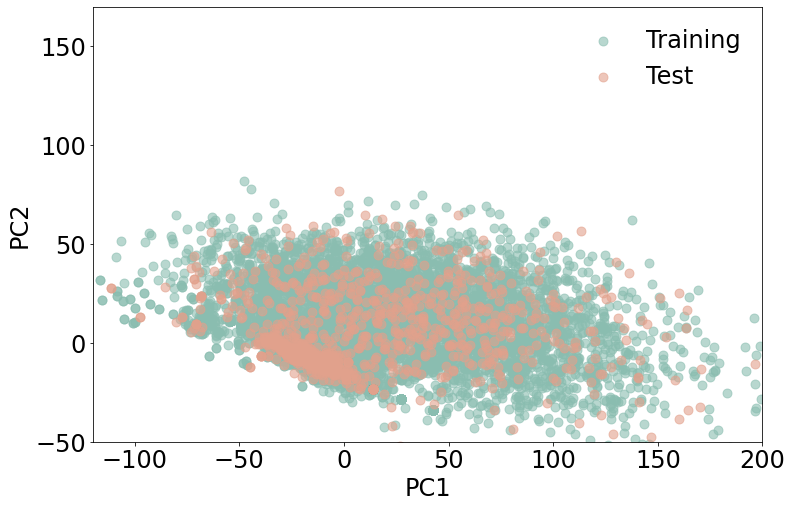

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(Si_train_pc1, Si_train_pc2, c='#8ABDB0', alpha=0.6, s=80, label='Training')
ax.scatter(Si_test_pc1, Si_test_pc2, c='#E2A18C', alpha=0.6, s=80, label='Test')

from matplotlib import ticker

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

plt.legend(fontsize=24, frameon=False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.xlim(-120, 200)
plt.ylim(-50, 170)

plt.savefig('images/Si_pca.png', bbox_inches='tight')

### 1.5 Use the DFT-computed energy and forces as targets and train linear regression model

Split the dataset into three lists:
 - list of structure objects [Structure object for each structure]
 - list of energies [total_energy for each structure], 
 - list of forces [n x 3 forces array for each n-atom structure], n can be different for different structures.

In [18]:
Si_train_structures = [d['structure'] for d in Si_train_data]
Si_train_energies = [d['outputs']['energy'] for d in Si_train_data]
Si_train_forces = [d['outputs']['forces'] for d in Si_train_data]

print(" # of structures in Si data: {}\n".format(len(Si_train_structures)),
      "# of energies in Si data: {}\n".format(len(Si_train_energies)),
      "# of forces in Si data: {}\n".format(len(Si_train_forces)),
      "first item in energies: {}\n".format(Si_train_energies[0]),
      "first item in forces: (n x 3 array)\n", np.array(Si_train_forces[0]))

 # of structures in Si data: 214
 # of energies in Si data: 214
 # of forces in Si data: 214
 first item in energies: -295.49753016
 first item in forces: (n x 3 array)
 [[-2.98187262e+00  6.06918700e-01  3.48143607e+00]
 [ 1.02961593e+00 -1.36964870e-01 -2.82125210e-01]
 [ 1.29123700e+00  2.50367684e+00  1.80272790e-01]
 [-5.00296970e-01 -6.82836740e-01 -2.67411757e+00]
 [-1.24770628e+00  5.45267640e-01  4.50551660e-01]
 [ 2.58664300e-01 -1.20841700e+00  1.41784669e+00]
 [ 1.01186331e+00 -9.74902540e-01  1.38438155e+00]
 [-1.19321410e+00  1.55031482e+00 -2.97242220e-01]
 [ 9.70732690e-01  9.35893690e-01  5.86275000e-03]
 [-1.94383380e-01  7.47415190e-01  3.83568370e-01]
 [ 8.03060510e-01 -4.97520690e-01  1.79911729e+00]
 [-2.08774090e-01  2.11837320e-01  1.60493000e-03]
 [ 1.12463610e-01  1.16400610e-01  2.14723700e-02]
 [-1.01784245e+00 -3.91863000e-02 -1.97045880e-01]
 [-1.12363790e-01 -4.69982000e-03 -5.76367900e-01]
 [ 9.82770190e-01 -1.71292947e+00  5.82678230e-01]
 [-2.59292800e

Let's use the features with pot_fit = True, i.e., 1+3n features for n-atom structure

In [19]:
Si_features = per_force_features
print("# of features generated: {}".format(Si_features.shape[0]))
Si_features

# of features generated: 39913


Si                                                          \
                    n         0-0-0         1-0-1         1-1-2         2-0-2   
input_index                                                                     
0           0     1.0  1.445318e+02  3.100438e+00  2.325116e-02  1.223494e+01   
            0_x   0.0 -7.090650e+01 -6.916710e+00  6.737850e-01  1.972100e+01   
            0_y   0.0  3.084910e+01  6.482520e+00 -1.623620e+00 -1.143210e+01   
            0_z   0.0  4.405790e+01  1.282430e+01 -1.457900e+00  3.324840e+01   
            1_x   0.0 -4.836970e+01 -7.543380e+00  1.300930e+00  1.064450e+01   
...               ...           ...           ...           ...           ...   
213         62_y  0.0 -8.726350e-14 -8.519230e-15 -1.582500e-15 -3.463900e-14   
            62_z  0.0  7.238650e-14  3.242200e-15 -5.867700e-16 -5.662140e-15   
            63_x  0.0 -1.261210e-13 -6.487870e-15 -6.626640e-16 -5.595520e-14   
            63_y  0.0 -1.132430e-13 -7.860900e-15 -1.122800e-15 -5.451200e-14   
            63_z  0.0 -1.181280e-13 -6.682150e-15 -1.314490e-15 -4.851670e-14   

                                                                          \
                         2-1-3         2-2-2         2-2-4         3-0-3   
input_index                                                                
0           0    -9.810799e-01  4.029527e-01  1.682071e+00  4.591677e+01   
            0_x   6.980560e-01 -1.139610e+00 -2.172550e-01 -1.042570e+01   
            0_y   1.388040e+00  3.692330e+00  2.673230e+00  1.718220e+01   
            0_z   6.343210e-01  1.171410e+01 -1.037380e-01 -1.181130e+01   
            1_x   3.384630e-02 -8.952580e-01  1.503340e+00 -2.881600e+00   
...                        ...           ...           ...           ...   
213         62_y  2.040030e-15  9.992010e-16  4.829470e-15  7.854830e-15   
            62_z  2.706170e-15 -8.798520e-15 -1.104670e-14  6.150640e-14   
            63_x -5.551120e-16 -2.886580e-15  6.661340e-15 -4.107830e-15   
            63_y  6.938890e-17 -7.771560e-16  7.882580e-15  4.801710e-15   
            63_z  1.595950e-16 -3.635980e-15  6.383780e-15  3.608220e-15   

                                ...                                            \
                         3-1-4  ...         7-3-8         7-4-7         7-5-8   
input_index                     ...                                             
0           0    -1.099226e+00  ...  1.682001e+01  1.628017e+01  1.562129e+01   
            0_x   6.515700e+00  ... -1.765000e+01 -3.713170e+01  5.289370e+00   
            0_y   1.670860e+00  ... -1.495090e+00 -4.376760e+01  1.524140e+00   
            0_z   8.022540e+00  ... -1.608320e+01  4.274030e+01  3.732590e+00   
            1_x  -1.690870e+00  ... -2.704040e+00  7.558510e+00 -1.381700e+01   
...                        ...  ...           ...           ...           ...   
213         62_y  6.522560e-15  ... -9.603430e-15 -2.856050e-14  7.682740e-14   
            62_z -3.330670e-15  ...  1.657010e-14 -6.313010e-14  3.408380e-14   
            63_x  6.217250e-15  ...  4.884980e-15  7.438490e-15  4.674040e-14   
            63_y  6.994410e-15  ...  9.547920e-15  1.081080e-14  5.007110e-14   
            63_z  5.787040e-15  ...  6.689090e-15 -1.221250e-15  5.237480e-14   

                                                                          \
                         7-6-7         7-7-8         8-0-8         8-2-8   
input_index                                                                
0           0     1.360803e+01  1.786809e+01  1.249334e+02  5.897539e+00   
            0_x  -1.926450e+01 -2.382950e+01  4.268430e+01  1.295200e+01   
            0_y  -2.529970e+01 -3.392610e+01  1.179710e+02  1.062720e+01   
            0_z   2.473390e+00  2.151440e+01 -1.806530e+01 -2.992900e+00   
            1_x   9.465690e+00 -5.476140e+00 -1.023770e+02  7.931080e+00   
...                        ...           ...           ...           ...   


pool_from - Method to convert structures and their properties in to datapool format; ([dict]) returned

convert_docs - http://maml.ai/maml.utils.html?highlight=convert_docs#maml.utils.convert_docs

In [20]:
Si_train_pool = pool_from(Si_train_structures, Si_train_energies, Si_train_forces)
_, Si_df = convert_docs(Si_train_pool)
print("# of targets: ", len(Si_df))
Si_df

# of targets:  39913


,y_orig,n,dtype
0,-295.497530,63.0,energy
1,-2.981873,1.0,force
2,0.606919,1.0,force
3,3.481436,1.0,force
4,1.029616,1.0,force
...,...,...,...
39908,0.000000,1.0,force
39909,-0.000000,1.0,force
39910,-0.000000,1.0,force
39911,-0.000000,1.0,force


Create targets per atom (energy per atom = total_energies / num_atoms, force components per atom = $f_{x}$, $f_{y}$, $f_{z}$.

Use sklearn LinearRegression model to fit the features and targets, both simple linear model and weighted linear model are obtained

In [21]:
##### Simple Linear regression
y = Si_df['y_orig']/Si_df['n']  
x = Si_features

simple_model = LinearRegression()
simple_model.fit(x, y)

##### Increase the weights of energies since the number of forces are overwhelming
weights = np.ones(len(Si_df['dtype']), )
weights[Si_df['dtype'] == 'energy'] = 10000
weights[Si_df['dtype'] == 'force'] = 1

weighted_model = LinearRegression()
weighted_model.fit(x, y, sample_weight=weights)

print("# of parameters in simple linear model: {}\n".format(len(simple_model.coef_)), 
      "parameters in simple linear model: \n", simple_model.coef_, "\n")
print("# of parameters in weighted linear model: {}\n".format(len(weighted_model.coef_)), 
      "parameters in weighted linear model: \n", weighted_model.coef_)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# of parameters in simple linear model: 56
 parameters in simple linear model: 
 [-7.17526712e+00  1.57544249e-03  1.17208568e-02  5.67342659e-02
 -1.13577337e-02  1.87525063e-01  3.23172385e-02  7.04309532e-02
  2.80963664e-02  6.64202157e-02  1.03177041e-01  7.17117589e-02
  1.17309867e-02 -7.96954695e-03  1.46594764e-02  1.53085349e-02
  2.87835561e-02  3.71809333e-02 -2.19042984e-02 -4.38868194e-03
 -1.41625053e-02 -1.33725106e-02 -1.36989174e-03  6.91347939e-03
  1.95887445e-02  2.70719246e-02  2.64809010e-02 -6.11480371e-03
 -3.45978598e-03 -3.39108667e-02 -1.21696768e-03 -1.61343672e-02
 -3.71845950e-03  1.43329473e-03  1.39366528e-02  3.30966021e-02
  1.46468933e-02  4.92030102e-03 -1.18204376e-02  1.39783893e-03
 -1.60886688e-02 -4.57996237e-03 -3.51149315e-03  3.68512111e-04
  6.86862116e-03  2.22722426e-02 -6.91655612e-05 -1.72342774e-03
 -1.01915427e-02 -9.21389190e-03 -3.70448003e-04 -4.29185692e-04
  8.99966411e-03  6.21716099e-04  2.89378324e-03  1.58315186e-03] 

# of p

Predict the energy and forces using fitted machine learning models, get the errors of energies and forces

In [22]:
energy_indices = np.argwhere(np.array(Si_df["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(Si_df["dtype"]) == "force").ravel()

simple_predict_y = simple_model.predict(x)
weighted_predict_y = weighted_model.predict(x)

original_energy = y[energy_indices]
original_forces = y[forces_indices]
simple_predict_energy = simple_predict_y[energy_indices]
simple_predict_forces = simple_predict_y[forces_indices]
weighted_predict_energy = weighted_predict_y[energy_indices]
weighted_predict_forces = weighted_predict_y[forces_indices]

print(" Simple model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, simple_predict_energy) * 1000),
      "Simple model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, simple_predict_forces)),
      "Weighted model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, weighted_predict_energy) * 1000),
      "Weighted model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, weighted_predict_forces)),)

 Simple model energy MAE: 54.924 meV/atom
 Simple model forces MAE: 0.129 eV/Å
 Weighted model energy MAE: 6.009 meV/atom
 Weighted model forces MAE: 0.135 eV/Å



/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## 2. Potential development & Materials Property Predictions

### 2.1 SNAP Potential development  

Wrap the bispectrum coefficients describer and linear regression model together. These are two inputs for the [SNAPotential](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_snap.py) object from maml package. Use the train() method of the SNAPotential. Three lists of respective structures, energies, and forces array are inputs for the train() method.

In [23]:
# Three lists of structures, energies, and forces array.
Si_train_structures = [d['structure'] for d in Si_train_data]
Si_train_energies = [d['outputs']['energy'] for d in Si_train_data]
Si_train_forces = [d['outputs']['forces'] for d in Si_train_data]
Si_group = []
for i in range(len(Si_train_data)):
    Si_group.append(Si_train_data[i]['group'])
Si_num_atoms = [d['num_atoms'] for d in Si_train_data]
Si_groups = []
for i in range(len(Si_train_data)): 
    Si_groups = Si_groups + [Si_group[i]]*(1 + 3*Si_num_atoms[i])

# Set the external weights.
Si_train_pool = pool_from(Si_train_structures, Si_train_energies, Si_train_forces)
_, Si_df = convert_docs(Si_train_pool)
Si_df["group"] = Si_groups
weights = np.ones(len(Si_df['dtype']), )
weights[(Si_df["dtype"] == "energy") & (Si_df["group"] == "Elastic")] = 2958.711
weights[(Si_df["dtype"] == "force") & (Si_df["group"] == "Elastic")] =  62.225
weights[(Si_df["dtype"] == "energy") & (Si_df["group"] == "Surface")] = 7882.800
weights[(Si_df["dtype"] == "force") & (Si_df["group"] == "Surface")] =  70.138
weights[(Si_df["dtype"] == "energy") & (Si_df["group"] == "AIMD-NVT")] = 2918.824
weights[(Si_df["dtype"] == "force") & (Si_df["group"] == "AIMD-NVT")] = 21.200
weights[(Si_df["dtype"] == "energy") & (Si_df["group"] == "Vacancy")] = 9307.700
weights[(Si_df["dtype"] == "force") & (Si_df["group"] == "Vacancy")] = 26.388

# Initialize the bispectrum coefficients describer and linear regression model
element_profile = {'Si': {'r': 0.5, 'w': 1.0}}
describer = BispectrumCoefficients(rcutfac=4.9, twojmax=8, 
                                   element_profile=element_profile, quadratic=False, 
                                   pot_fit=True, include_stress=False)
ml_model = LinearRegression()
skl_model = SKLModel(describer=describer, model=ml_model)
Si_snap = SNAPotential(model=skl_model)

# Train the potential with lists of structures, energies, forces
Si_snap.train(Si_train_structures, Si_train_energies, Si_train_forces, sample_weight=weights)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### 2.2 Evaluate the energy and forces prediction

Use the fitted snap to evaluate energy and forces errors. 

In [25]:
Si_test_structures = [d['structure'] for d in Si_test_data]
Si_test_energies = [d['outputs']['energy'] for d in Si_test_data]
Si_test_forces = [d['outputs']['forces'] for d in Si_test_data]

df_orig, df_predict = Si_snap.evaluate(test_structures=Si_test_structures, 
                                       test_energies=Si_test_energies,
                                       test_forces=Si_test_forces)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Draw the parity plots of energy and forces for Ni, the x axis is DFT computed values, the y axis is SNAP predicted values.

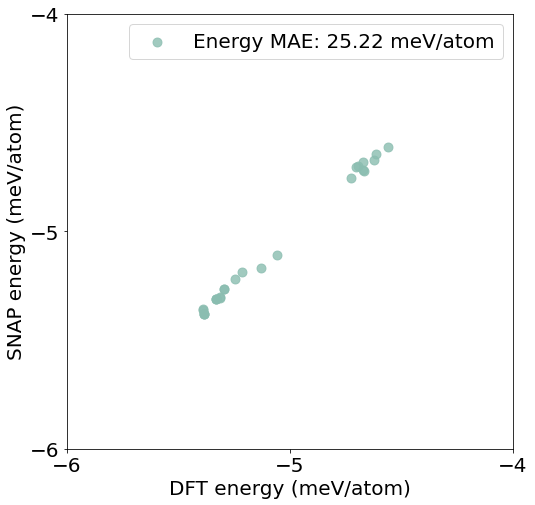

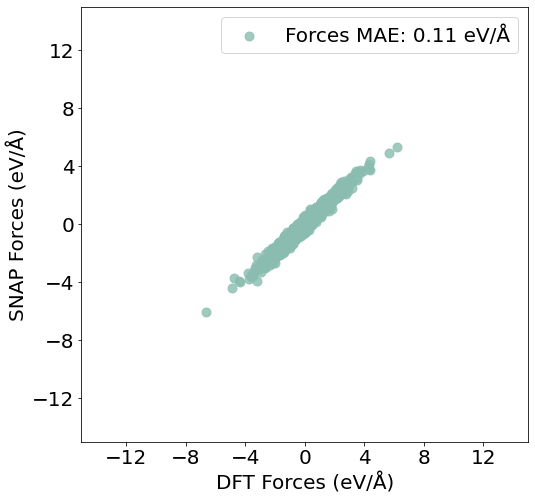

In [36]:
energy_indices = np.argwhere(np.array(df_orig["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(df_orig["dtype"]) == "force").ravel()
orig = df_orig['y_orig']/df_orig['n']
predict = df_predict['y_orig']/df_orig['n']

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(orig[energy_indices], predict[energy_indices], color='#8ABDB0', s=80, alpha=0.8, 
            label="Energy MAE: {:.2f} meV/atom".format(mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000))
ax1.set_xlim(-6, -4)
ax1.set_ylim(-6, -4)
ax1.set_xlabel("DFT energy (meV/atom)", fontsize=20)
ax1.set_ylabel("SNAP energy (meV/atom)", fontsize=20)
ax1.legend(fontsize=20)

from matplotlib import ticker

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))

fig, ax2 = plt.subplots(figsize=(8, 8))
ax2.scatter(orig[forces_indices], predict[forces_indices], color='#8ABDB0', s=80, alpha=0.8,
            label="Forces MAE: {:.2f} eV/Å".format(mean_absolute_error(orig[forces_indices], predict[forces_indices])))
ax2.set_xlim(-15, 15)
ax2.set_ylim(-15, 15)
ax2.set_xlabel("DFT Forces (eV/Å)", fontsize=20)
ax2.set_ylabel("SNAP Forces (eV/Å)", fontsize=20)
ax2.legend(fontsize=20)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(4))

In [32]:
mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000

25.22419471179564

In [33]:
mean_absolute_error(orig[forces_indices], predict[forces_indices])

0.10759492782796753

### 2.3 Predict basic properties

**1. lattice constants prediction** See [LatticeConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

inputs:
 - ff_settings: The potential object. Take SNAPotential as input here.

In [37]:
Si_cell = Structure.from_spacegroup(sg='Fd-3m', species=['Si'], lattice=Lattice.cubic(5.67), coords=[[0, 0, 0]])

Si_lc_calculator = LatticeConstant(Si_snap)
a, b, c = Si_lc_calculator.calculate([Si_cell])[0]
print('Si', 'Lattice a: {:.3f} Å, Lattice b: {:.3f} Å, Lattice c: {:.3f} Å'.format(a, b, c))

Si Lattice a: 5.450 Å, Lattice b: 5.450 Å, Lattice c: 5.450 Å


**2. elastic constants prediction** See [ElasticConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.
 - atom_type: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).

In [38]:
Si_ec_calculator = ElasticConstant(ff_settings=Si_snap)
Si_elastic_prop = Si_ec_calculator.calculate(Si_train_structures)
print('Si', ' C11: {:.0f} GPa'.format(Si_elastic_prop[0]), 'C12: {:.0f} GPa'.format(Si_elastic_prop[1]),
      'C44: {:.0f} GPa'.format(Si_elastic_prop[2]), 'Bulk Modulus: {:.0f}'.format(Si_elastic_prop[3]))

TypeError: unsupported format string passed to tuple.__format__

In [39]:
print('Si', ' C11: {:.0f} GPa'.format(Si_elastic_prop[0][0]), 'C12: {:.0f} GPa'.format(Si_elastic_prop[0][1]),
      'C44: {:.0f} GPa'.format(Si_elastic_prop[0][2]), 'Bulk Modulus: {:.0f}'.format(Si_elastic_prop[0][3]))

Si  C11: -598 GPa C12: -280 GPa C44: -385 GPa Bulk Modulus: -364


**3. Vacancy formation energy prediction** See [DefectFormation calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - specie: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.

In [40]:
Si_vacancy_calcualtor = DefectFormation(ff_settings=Si_snap, specie='Si', lattice='diamond', alat=5.67)
formation_energy = Si_vacancy_calcualtor.calculate()
print('Si Vacancy formation energy: {:.2f} eV'.format(formation_energy))

Si Vacancy formation energy: 2.08 eV
